In [1]:
import diffusion_imaging
from diffusion_imaging.models import NODDIModel, BallStickModel
from diffusion_imaging.handlers.containers import MRI, Patient, build_mri
from diffusion_imaging.handlers.handlers import make_handler
from dipy.core.gradients import gradient_table
from dipy.segment.mask import median_otsu
import argparse
import logging
import numpy as np
import dipy
import os
import warnings
import dill
import nibabel as nib

In [2]:
from abc import ABC, abstractmethod

In [3]:
class HandlerBase(ABC):
    """
    Base class for the Handler functions for the loading of data
    """
    
    @abstractmethod
    def load(self):
        pass

In [4]:
class LocalHandler(HandlerBase):
    
    def __init__(self, patient_directory, label):
        self.patient_directory = patient_directory
        self.label = label
        
    def _filter(self, file, filters):
        
        for filt in filters:
            if filt in file:
                return True
            
        return False
        
    def _get_files(self, path, filters=[]):
        
        grouped_file_paths = []
        files = os.listdir(self.patient_directory)
        
        filtered = []
        for file in files:
            if len(filters):
                if not self._filter(file, filters):
                    filtered.append(os.path.join(self.patient_directory, file))
            else:
                filtered.append(os.path.join(self.patient_directory, file))
        
        return filtered
    
    def _load_dwi(self, file):
        image = nib.load(file)
        return image
    
    def _make_mri(self, filtered_files):

        # The group is the group associated with the specific 'dir*'
        # this includes both LR and RL orientations
        for file in filtered_files:
            if "bvec" in os.path.basename(file):
                bvecs_file_path = file
            elif "bval" in os.path.basename(file):
                bvals_file_path = file
            elif os.path.basename(file).endswith('.nii.gz'):
                dwi_data = self._load_dwi(file)
                image = dwi_data.get_data()
                aff = dwi_data.affine
        
        # Take the 
        gtab = gradient_table(bvals_file_path, bvecs_file_path)
        
        nifti_image = nib.Nifti1Image(image, aff)
        
        mri = build_mri(nifti_image, gtab, self.label)
        
        return mri
    
    def _make_patient(self, directory):
        
        patient = Patient()
        filtered_files = self._get_files(self.patient_directory)
        patient.directory = self.patient_directory
        patient.mri = self._make_mri(filtered_files)
        
        return patient
    
    def load(self):
        
        return self._make_patient(self.patient_directory)

In [2]:
path = "D:\\Users\\boywi\\Documents\\THESIS_DATA\\HCP\\Diffusion\\100307\\T1w\\Diffusion"
path = "D:\\Users\\boywi\\Documents\\THESIS_DATA\\021_S_2077"
lh = make_handler(path, 'hcp')
patient = lh.load()

['D:\\Users\\boywi\\Documents\\THESIS_DATA\\021_S_2077\\021_S_2077.bval', 'D:\\Users\\boywi\\Documents\\THESIS_DATA\\021_S_2077\\021_S_2077.bvec', 'D:\\Users\\boywi\\Documents\\THESIS_DATA\\021_S_2077\\021_S_2077.nii.gz', 'D:\\Users\\boywi\\Documents\\THESIS_DATA\\021_S_2077\\021_S_2077.pkl']


C:\Users\boywi\Miniconda3\envs\dmipy\lib\site-packages\dmipy-0.1.dev0-py3.7.egg\dmipy\core\acquisition_scheme.py:871: UserWarning: pulse_separation (big_delta) or pulse_duration (small_delta) are not defined in the Dipy gtab. This means the resulting DmipyAcquisitionScheme cannot be used with CompartmentModels that need these.


In [4]:
from dipy.segment.mask import bounding_box
import matplotlib.pyplot as plt

In [12]:
min_indicies, max_indicies = bounding_box(patient.mri.data)
min_x, min_y, min_z, min_t = min_indicies
max_x, max_y, max_z, max_t = max_indicies

In [4]:
patient.mri.data.shape

(256, 256, 59, 46)

In [5]:
min_indicies, max_indicies = bounding_box(patient.mri.mask)
min_x, min_y, min_z= min_indicies
max_x, max_y, max_z = max_indicies

In [36]:
patient.mri.mask[min_x:max_x, min_y:max_y].shape

(104, 128, 59)

In [41]:
masked, mask = median_otsu(patient.mri.mask)

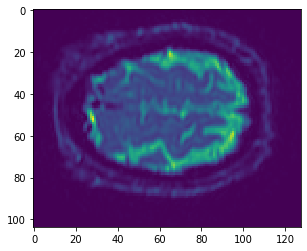

In [6]:
plt.imshow(patient.mri.data[min_x:max_x, min_y:max_y, 50, 0])

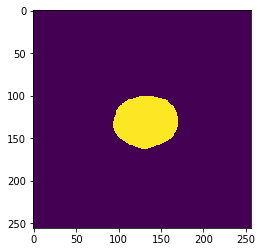

In [7]:
plt.imshow(patient.mri.mask[..., 50])

In [7]:
class HPCHandler(LocalHandler):
    
    def __init__(self, patient_directory, label):
        LocalHandler.__init__(patient_directory, label)
    
    def load(self, index_range, middle_slice=False):
        
        patient = Patient()
        filtered_files = self._get_files(self.patient_directory)
        patient.directory = self.patient_directory
        patient.mri = self._make_mri(filtered_files)
        if len(index_range) == 2:
            patient.mri.data = data[:, :, index_range[0] : index_range[1], :]
        else:
            raise IndexError("index_range must be a list of two values indicating the start and exclusive end of a range")
        
        

In [8]:
class HCPLocalHandler(HandlerBase):
    """
    Class to hanlde the loading of the specific patient files from the Human Connectome Project
    """
    
    def __init__(self, config):
        self.config = config
        self.patient_directory = config['patient_directory']
        self.sub_directory = os.path.join("T1w", "Diffusion")
        self.label = "hcp"
        
    def _get_files(self, path):
        
        grouped_file_paths = []
        base = os.path.join(self.patient_directory, path, self.sub_directory)
        files = os.listdir(base)
        
        filtered = []
        for file in files:
            if not "eddylogs" in file and not "nodif_brain_mask" in file and not "grad_dev" in file:
                filtered.append(os.path.join(base, file))
        
        return filtered
        
    def _load_dwi(self, file):
        image = nib.load(file)
        return image
    
    def _load_bvec(self, file):
        return np.loadtxt(file)
    
    def _load_bval(self, file):
        return np.loadtxt(file)
    
    def _make_mri(self, filtered_files):

        # The group is the group associated with the specific 'dir*'
        # this includes both LR and RL orientations
        print(filtered_files) 
        for file in filtered_files:
            if "bvec" in os.path.basename(file):
                bvecs_file_path = file
            elif "bval" in os.path.basename(file):
                bvals_file_path = file
            elif os.path.basename(file).endswith('.nii.gz'):
                dwi_data = self._load_dwi(file)
                image = dwi_data.get_data()
                aff = dwi_data.affine
        
        # Take the 
        gtab = gradient_table(bvals_file_path, bvecs_file_path)
        
        nifti_image = nib.Nifti1Image(image, aff)
        
        mri = MRI(nifti_image, gtab, self.label)
        
        return mri
        
    def load(self):
        
        patients = []
        for patient in os.listdir(self.patient_directory):
            p = Patient(patient_number=patient)
            
            filtered_files = self._get_files(os.path.join(self.patient_directory,
                                                         patient))
            p.directory = os.path.join(self.patient_directory, patient) 
            p.mri = self._make_mri(filtered_files)
            patients.append(p)
            
        return patients
        

class DMIPYLocalHandler(HCPLocalHandler):
    def __init__(self, config):
        self.config = config
        self.patient_directory = config['patient_directory']
        self.label = "andi"

    def _get_files(self, path=None):

        base = os.path.join(self.patient_directory, path)
        files = os.listdir(base)
        files_full_dir = []

        for file in files:
            files_full_dir.append(os.path.join(self.patient_directory, path, file))

        return files_full_dir


class LocalHandler(HandlerBase):
    """
    Class to handle the loading of local files
    """
    
    def __init__(self, config):
        self.config = config
        self.dwi = None
        self.bvec = None
        self.bval = None
        self.aff = []
    
    def _get_files(self, path, end_extention):
        
        out_data = []
        
        for file in os.listdir(path):
            if file.endswith(end_extention) and \
                (not "SBRef" in file and \
                 not "BIAS" in file):
                out_data.append(os.path.join(path, file))
        
        return out_data
    
    
    def _load_dwi(self, files):
        
        data = []
        aff = []
        
        for file in files:
            loaded = nib.load(file)
            data.append(loaded.get_data())
            
        aff = loaded.affine
        
        return (data, aff)
    
    
    def _load_bvec(self, files):
        
        data = []
        for file in files:
            data.append(np.loadtxt(file))
        
        return data
    
    
    def _load_bval(self, files):
        
        data = []
        for file in files:
            data.extend(np.loadtxt(file))
        
        return data
    
    
    def _get_data(self, path, end_extention):
        
        switch = {
            ".nii.gz": self._load_dwi,
            ".bvec": self._load_bvec,
            ".bval": self._load_bval
        }
        
        paths = self._get_files(path, end_extention)
        data = switch[end_extention](paths)
        
        return data
        
    
    def load(self):
        
        dwi_path = self.config['dwi_path']
        bvec_path = self.config['bvec_path']
        bval_path = self.config['bval_path']
        
        dwi, af = self._get_data(dwi_path, ".nii.gz")
        bvec = self._get_data(bvec_path, ".bvec")
        bval = self._get_data(bval_path, ".bval")
        
        out = [nib.Nifti1Image(np.concatenate(dwi, -1), af),
               gradient_table(bval, np.concatenate(bvec, -1))]
        
        return out